In [6]:
import tensorflow as tf
import tensorflow_datasets as tfds
import albumentations as A
import warnings

warnings.filterwarnings('ignore')
print('tf.__version__ : ', tfds.__version__)
print('tf_datasets.__version__ : ', tf.__version__)
print('albumentations.__version__ : ', A.__version__)

tf.__version__ :  4.9.2
tf_datasets.__version__ :  2.8.0
albumentations.__version__ :  1.3.1


## 1) Pixel-level augmentations

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from functools import partial
from albumentations import (
    Compose, JpegCompression, HueSaturationValue, RandomContrast, RandomGamma, RandomBrightness,
    Blur, HistogramMatching, Equalize, ColorJitter, CLAHE, GaussianBlur, GaussNoise, MedianBlur, MotionBlur, RGBShift,
    RandomFog, RandomSnow, RandomRain)

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [13]:
# load in the tf_flowers dataset
data, info = tfds.load(name="tf_flowers", split="train", as_supervised=True, with_info=True)

In [19]:
# define visualization function
def view_image(ds):
    image, label = next(iter(ds)) # extract 1 batch from the dataset
    image = image.numpy()
    label = label.numpy()
    
    fig = plt.figure(figsize=(22, 22))
    for i in range(20):
        ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
        ax.imshow(image[i])
        ax.set_title(f"Label: {label[i]}")

In [21]:
# Instantiate augments
# we can apply as many augments we want and adjust the values accordingly
# here I have chosen the augments and their arguments at random
transforms = Compose([
            RandomBrightness(limit=0.1),
            JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
            HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            RandomContrast(limit=0.2, p=0.5),
            RandomGamma(gamma_limit=(80, 120)),
            Blur(blur_limit=(3, 7)),
            Equalize(),
            ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
            CLAHE(clip_limit=4.0, tile_grid_size=(8, 8)),
            GaussianBlur(blur_limit=(3, 7), sigma_limit=(0, 0)),
            GaussNoise(var_limit=(10.0, 50.0), mean=0),
            MedianBlur(blur_limit=(7, 7)),
            MotionBlur(blur_limit=(7, 7)),
            RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20,),
            RandomFog(fog_coef_lower=0.3, fog_coef_upper=1, alpha_coef=0.08),
            RandomSnow(snow_point_lower=0.1, snow_point_upper=0.3, brightness_coeff=2.5),
            RandomRain(slant_lower=-10, slant_upper=10, drop_length=20, drop_width=1,
                       drop_color=(200, 200, 200), blur_value=7, brightness_coefficient=0.7)
        ])

def aug_fn(image, img_size):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img / 255.0, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    return aug_img

def process_data(image, label, img_size):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
    return aug_img, label

# create dataset
ds_alb = data.map(partial(process_data, img_size=120), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

In [22]:
def set_shapes(img, label, img_shape=(120,120,3)):
    img.set_shape(img_shape)
    label.set_shape([])
    return img, label

In [23]:
ds_alb = ds_alb.map(set_shapes, num_parallel_calls=AUTOTUNE).batch(32).prefetch(AUTOTUNE)
ds_alb

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

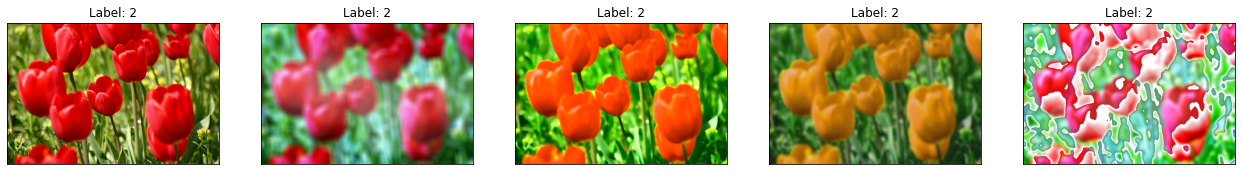

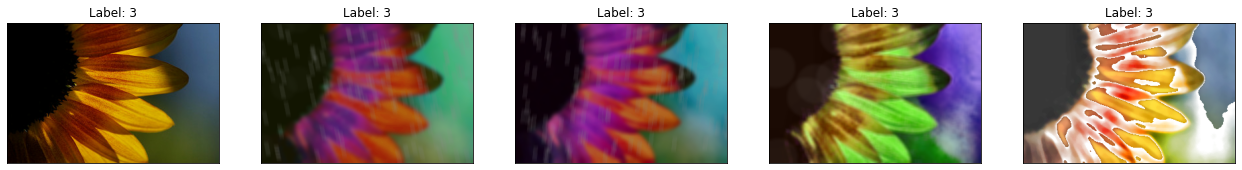

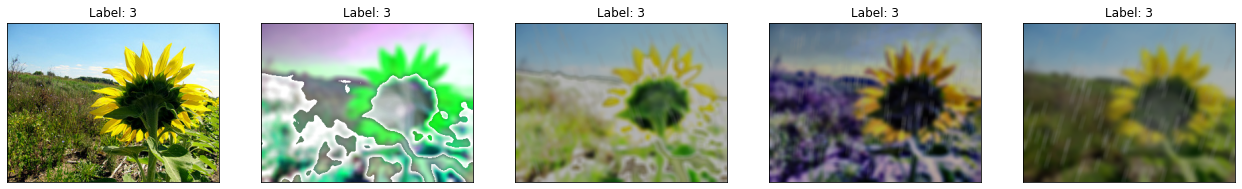

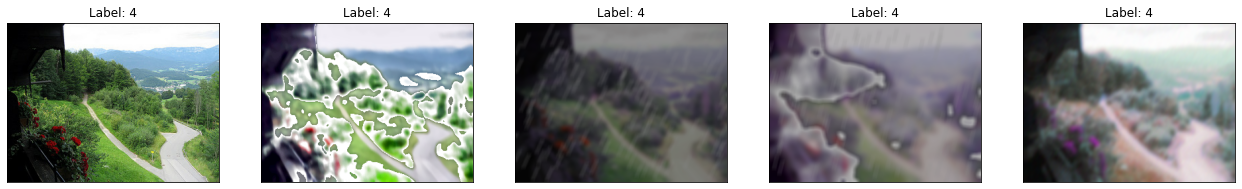

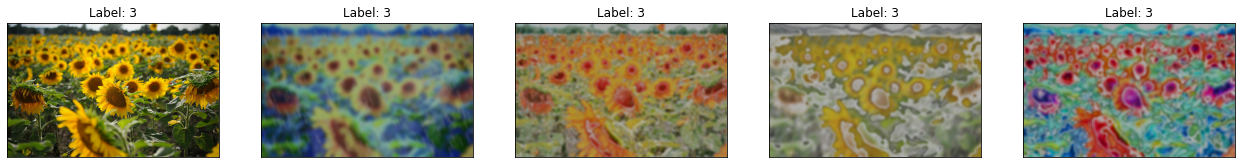

In [41]:
ds_alb = ds_alb.map(set_shapes, num_parallel_calls=AUTOTUNE).batch(32).prefetch(AUTOTUNE)

original = [0, 5, 10, 15]

for image, label in data.take(5):
    fig = plt.figure(figsize=(22, 14))
    for i in range(5):
        ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
        if i in original:
            ax.imshow(image)
            ax.set_title(f"Label: {label}")
        else:
            augmented = transforms(image=np.array(image))
            ax.imshow(augmented["image"])
            ax.set_title(f"Label: {label}")

In [131]:
from PIL import Image

src_img = np.array(Image.open('source.png'))
target_image = np.array(Image.open('reference.png'))

In [142]:
target_hm = HistogramMatching(reference_images=['reference.png'], always_apply=True)
output = target_hm(image=src_img)

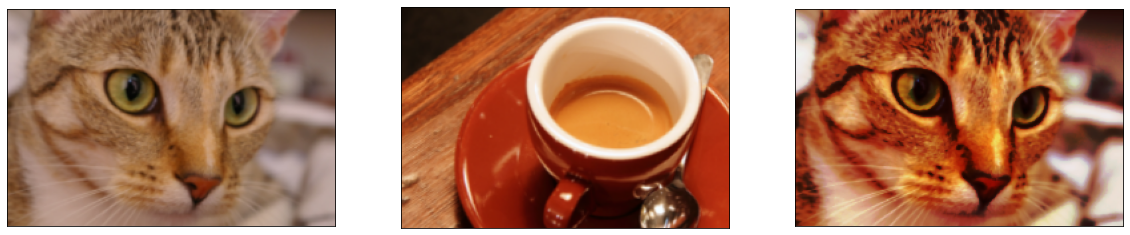

In [148]:
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(1, 3, 1, xticks=[], yticks=[])
ax.imshow(src_img)

ax = fig.add_subplot(1, 3, 2, xticks=[], yticks=[])
ax.imshow(target_image)

ax = fig.add_subplot(1, 3, 3, xticks=[], yticks=[])
ax.imshow(output['image']);

## 2) Spatial-level augmentations

In [149]:
import numpy as np
import matplotlib.pyplot as plt

from functools import partial
from albumentations import (
    Affine, Crop, CropAndPad, ElasticTransform, VerticalFlip, HorizontalFlip, GridDropout, MaskDropout, GridDistortion,
    ShiftScaleRotate)

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [150]:
# load in the tf_flowers dataset
data, info = tfds.load(name="tf_flowers", split="train", as_supervised=True, with_info=True)

In [151]:
# define visualization function
def view_image(ds):
    image, label = next(iter(ds)) # extract 1 batch from the dataset
    image = image.numpy()
    label = label.numpy()
    
    fig = plt.figure(figsize=(22, 22))
    for i in range(20):
        ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
        ax.imshow(image[i])
        ax.set_title(f"Label: {label[i]}")

In [155]:
# Instantiate augments
# we can apply as many augments we want and adjust the values accordingly
# here I have chosen the augments and their arguments at random
transforms = Compose([
            Affine(scale=0.5, translate_percent=0.5, rotate=[-180, 180], shear=[-180, 180]),
            CropAndPad(px=(0, 112)),
            ElasticTransform(alpha=1, sigma=50, alpha_affine=50),
            VerticalFlip(),
            HorizontalFlip(),
            GridDropout(ratio=0.5, fill_value=0),
            GridDistortion(num_steps=5, distort_limit=(-0.03, 0.03)),
            ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45,)
        ])

def aug_fn(image, img_size):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img / 255.0, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    return aug_img

def process_data(image, label, img_size):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
    return aug_img, label

# create dataset
ds_alb = data.map(partial(process_data, img_size=120), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

In [156]:
def set_shapes(img, label, img_shape=(120,120,3)):
    img.set_shape(img_shape)
    label.set_shape([])
    return img, label

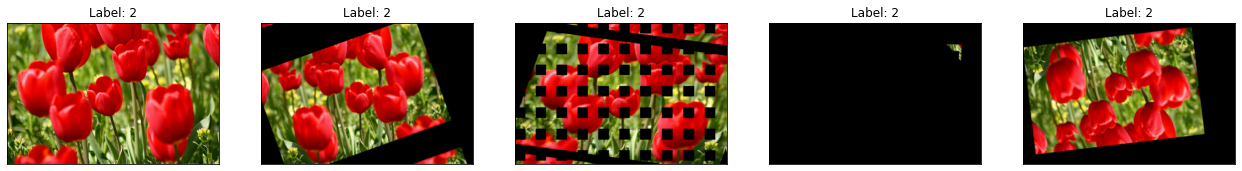

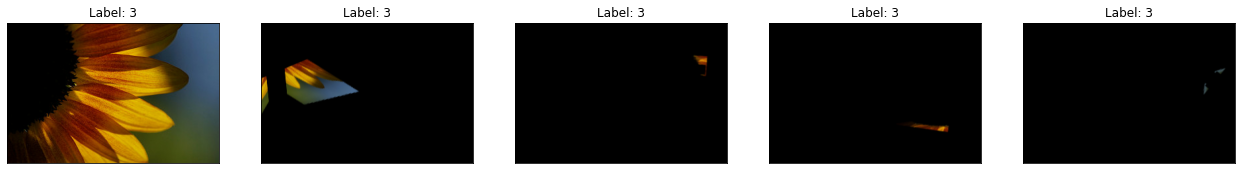

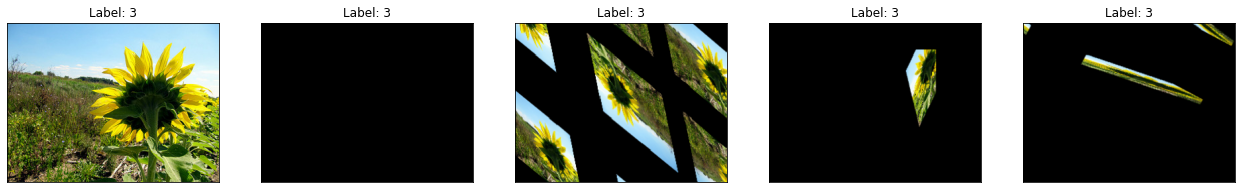

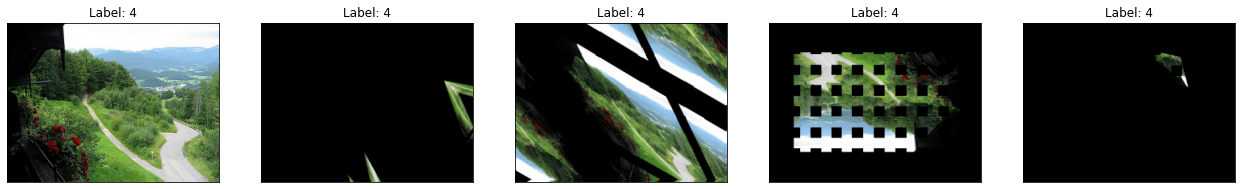

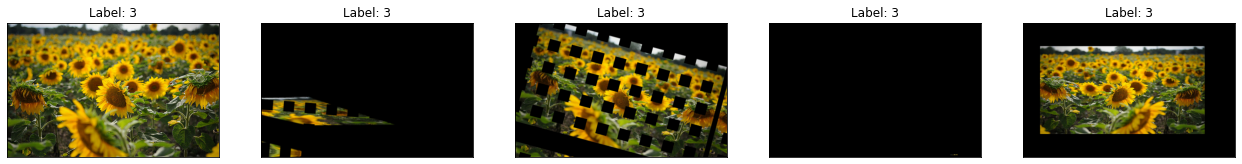

In [157]:
ds_alb = ds_alb.map(set_shapes, num_parallel_calls=AUTOTUNE).batch(32).prefetch(AUTOTUNE)

original = [0, 5, 10, 15]

for image, label in data.take(5):
    fig = plt.figure(figsize=(22, 14))
    for i in range(5):
        ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
        if i in original:
            ax.imshow(image)
            ax.set_title(f"Label: {label}")
        else:
            augmented = transforms(image=np.array(image))
            ax.imshow(augmented["image"])
            ax.set_title(f"Label: {label}")